<a href="https://colab.research.google.com/github/MikhailMikheev17/123/blob/master/Intrusion_Detection_System_with_ML%26DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'nslkdd:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F174616%2F394223%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240519%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240519T211139Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D1bfc9a2685901941999026187eafcd906ce3b1537ab838668310624a6246d393ac6ed9363b3b3e8470e2ec9bb9b5f69e4f83f84fb6ff29fffb50e584431a67ea7ba845c6cc81fc09947c5e691e864980946369564577e7e5f0fd7cda66666e8f7e8167643bd21ac3fd0ebe151aa44361551add85e2463ecd32747db22a14e7dcfccac4a97ea4451498b4eb3fc0dfc04f4f2157afef35427faede3b2f9493234eea64d8d9bf9623554162faeb6c1ddceee777e952a84988281f467f6f3a21615f3430545c8bf617ab96712fa917825c55802747639a32029f6d10ece3eefd947c555bf879697c09366a08c2ea7156c769aada82f0c42f83b3b8367a7c9251790d'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 14529600 bytes downloaded
Downloaded and uncompressed: nslkdd
Data source import complete.


# Problem Statement

<img src=https://www.vmware.com/content/dam/digitalmarketing/vmware/en/images/gallery/thumbnails/tn-vmware-overview-of-nsx-distributed-ids.jpg width=600/>

With the dramatic growth of computer networks usage and the huge increase in the number of applications running on top of it, network security is becoming increasingly while the all the systems suffers from security vulnerabilities, which could increase the attacks that could negatively affects the economy.
Therefore detecting vulnerabilities in the system in the network has been more important and need to be done as accurate as possible in real time.
in this notebook a model will be created and trained using SVM classifier to distengush if there is an attack or not in the network packet.


## Intrusion detection systems

An Intrusion Detection System (IDS) is a system that monitors network traffic for suspicious activity and issues alerts when such activity is discovered. It is a software application that scans a network or a system for the harmful activity or policy breaching. Any malicious venture or violation is normally reported either to an administrator or collected centrally using a security information and event management (SIEM) system. A SIEM system integrates outputs from multiple sources and uses alarm filtering techniques to differentiate malicious activity from false alarms.

<img src=https://www.temok.com/blog/wp-content/uploads/2020/10/network2.jpg width=600/>

* Host-Based IDS (HIDS): A host-based IDS is deployed on a particular endpoint and designed to protect it against internal and external threats. Such an IDS may have the ability to monitor network traffic to and from the machine, observe running processes, and inspect the system’s logs. A host-based IDS’s visibility is limited to its host machine, decreasing the available context for decision-making, but has deep visibility into the host computer’s internals.
* Network-Based IDS (NIDS): A network-based IDS solution is designed to monitor an entire protected network. It has visibility into all traffic flowing through the network and makes determinations based upon packet metadata and contents. This wider viewpoint provides more context and the ability to detect widespread threats; however, these systems lack visibility into the internals of the endpoints that they protect.

Detection Method of IDS:

* Signature-based Method:
Signature-based IDS detects the attacks on the basis of the specific patterns such as number of bytes or number of 1’s or number of 0’s in the network traffic. It also detects on the basis of the already known malicious instruction sequence that is used by the malware. The detected patterns in the IDS are known as signatures.
Signature-based IDS can easily detect the attacks whose pattern (signature) already exists in system but it is quite difficult to detect the new malware attacks as their pattern (signature) is not known.

* Anomaly-based Method:
Anomaly-based IDS was introduced to detect unknown malware attacks as new malware are developed rapidly. In anomaly-based IDS there is use of machine learning to create a trustful activity model and anything coming is compared with that model and it is declared suspicious if it is not found in model. Machine learning-based method has a better-generalized property in comparison to signature-based IDS as these models can be trained according to the applications and hardware configurations.

## Importing necessary libraries

In [2]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import regularizers
import xgboost as xgb
from sklearn.decomposition import PCA
from sklearn import tree
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import metrics
pd.set_option('display.max_columns',None)
warnings.filterwarnings('ignore')
%matplotlib inline

## Exploring the dataset

In [3]:
# Read Train and Test dataset
data_train = pd.read_csv("../input/nslkdd/KDDTrain+.txt")

In [4]:
# Check data
data_train.head()

,0,tcp,ftp_data,SF,491,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.10,0.11,0.12,0.13,0.14,0.15,0.16,0.18,2,2.1,0.00,0.00.1,0.00.2,0.00.3,1.00,0.00.4,0.00.5,150,25,0.17,0.03,0.17.1,0.00.6,0.00.7,0.00.8,0.05,0.00.9,normal,20
0,0,udp,other,SF,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.0,0.00,normal,15
1,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.0,0.00,neptune,19
2,0,tcp,http,SF,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.0,0.01,normal,21
3,0,tcp,http,SF,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,normal,21
4,0,tcp,private,REJ,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,121,19,0.0,0.0,1.0,1.0,0.16,0.06,0.00,255,19,0.07,0.07,0.00,0.00,0.00,0.00,1.0,1.00,neptune,21


In [5]:
columns = (['duration','protocol_type','service','flag','src_bytes','dst_bytes','land','wrong_fragment','urgent','hot'
,'num_failed_logins','logged_in','num_compromised','root_shell','su_attempted','num_root','num_file_creations'
,'num_shells','num_access_files','num_outbound_cmds','is_host_login','is_guest_login','count','srv_count','serror_rate'
,'srv_serror_rate','rerror_rate','srv_rerror_rate','same_srv_rate','diff_srv_rate','srv_diff_host_rate','dst_host_count','dst_host_srv_count'
,'dst_host_same_srv_rate','dst_host_diff_srv_rate','dst_host_same_src_port_rate','dst_host_srv_diff_host_rate','dst_host_serror_rate'
,'dst_host_srv_serror_rate','dst_host_rerror_rate','dst_host_srv_rerror_rate','outcome','level'])

In [6]:
# Assign name for columns
data_train.columns = columns

In [7]:
data_train.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,outcome,level
0,0,udp,other,SF,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.0,0.00,normal,15
1,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.0,0.00,neptune,19
2,0,tcp,http,SF,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.0,0.01,normal,21
3,0,tcp,http,SF,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,normal,21
4,0,tcp,private,REJ,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,121,19,0.0,0.0,1.0,1.0,0.16,0.06,0.00,255,19,0.07,0.07,0.00,0.00,0.00,0.00,1.0,1.00,neptune,21


In [8]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125972 entries, 0 to 125971
Data columns (total 43 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     125972 non-null  int64  
 1   protocol_type                125972 non-null  object 
 2   service                      125972 non-null  object 
 3   flag                         125972 non-null  object 
 4   src_bytes                    125972 non-null  int64  
 5   dst_bytes                    125972 non-null  int64  
 6   land                         125972 non-null  int64  
 7   wrong_fragment               125972 non-null  int64  
 8   urgent                       125972 non-null  int64  
 9   hot                          125972 non-null  int64  
 10  num_failed_logins            125972 non-null  int64  
 11  logged_in                    125972 non-null  int64  
 12  num_compromised              125972 non-null  int64  
 13 

In [9]:
data_train.describe().style.background_gradient(cmap='Blues').set_properties(**{'font-family':'Segoe UI'})

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,level
count,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000
mean,287.146929,45567.100824,19779.271433,0.000198,0.022688,0.000111,0.204411,0.001222,0.395739,0.279253,0.001342,0.001103,0.302194,0.012669,0.000413,0.004096,0.000000,0.000008,0.009423,84.108207,27.738093,0.284487,0.282488,0.119959,0.121184,0.660925,0.063053,0.097322,182.149200,115.653725,0.521244,0.082952,0.148379,0.032543,0.284455,0.278487,0.118832,0.120241,19.504056
std,2604.525522,5870354.480801,4021285.112114,0.014086,0.253531,0.014366,2.149977,0.045239,0.489011,23.942137,0.036603,0.045155,24.399715,0.483937,0.022181,0.099370,0.000000,0.002817,0.096613,114.508828,72.636092,0.446457,0.447024,0.320437,0.323648,0.439624,0.180315,0.259831,99.206565,110.702886,0.448950,0.188922,0.308998,0.112564,0.444785,0.445670,0.306559,0.319460,2.291512
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.090000,0.000000,0.000000,82.000000,10.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.000000
50%,0.000000,44.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.000000,8.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,255.000000,63.000000,0.510000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000
75%,0.000000,276.000000,516.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,143.000000,18.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.060000,0.000000,255.000000,255.000000,1.000000,0.070000,0.060000,0.020000,1.000000,1.000000,0.000000,0.000000,21.000000
max,42908.000000,1379963888.000000,1309937401.000000,1.000000,3.000000,3.000000,77.000000,5.000000,1.000000,7479.000000,1.000000,2.000000,7468.000000,43.000000,2.000000,9.000000,0.000000,1.000000,1.000000,511.000000,511.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,21.000000


In [10]:
data_train.loc[data_train['outcome'] == "normal", "outcome"] = 'normal'
data_train.loc[data_train['outcome'] != 'normal', "outcome"] = 'attack'

In [11]:
def pie_plot(df, cols_list, rows, cols):
    fig, axes = plt.subplots(rows, cols)
    for ax, col in zip(axes.ravel(), cols_list):
        df[col].value_counts().plot(ax=ax, kind='pie', figsize=(15, 15), fontsize=10, autopct='%1.0f%%')
        ax.set_title(str(col), fontsize = 12)
    plt.show()

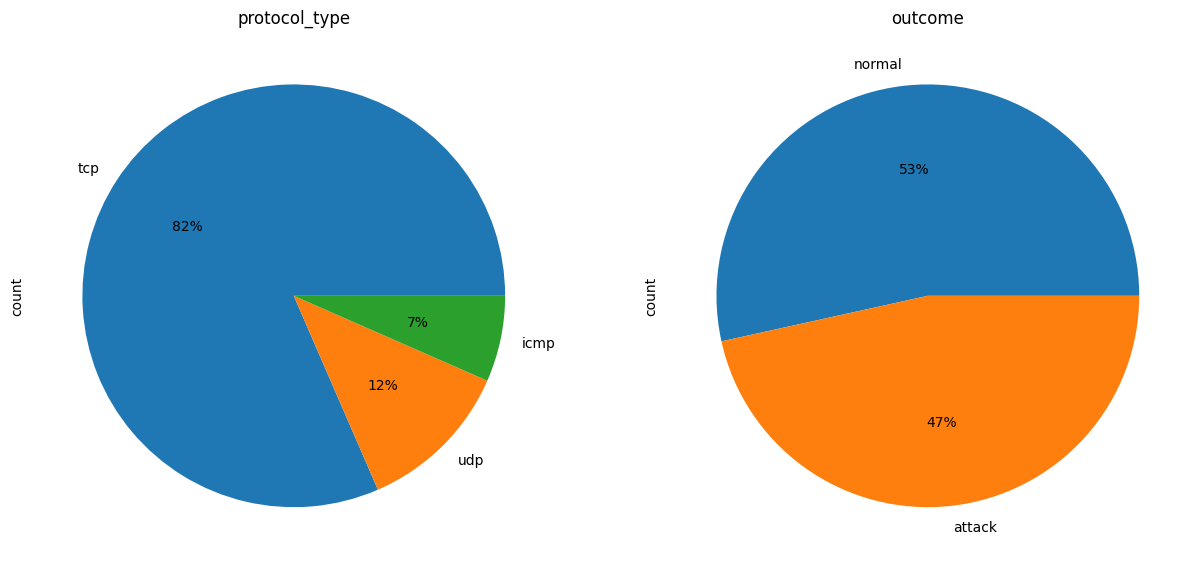

In [12]:
pie_plot(data_train, ['protocol_type', 'outcome'], 1, 2)

## Preprocessing the data

In [13]:
def Scaling(df_num, cols):
    std_scaler = RobustScaler()
    std_scaler_temp = std_scaler.fit_transform(df_num)
    std_df = pd.DataFrame(std_scaler_temp, columns =cols)
    return std_df

In [14]:
cat_cols = ['is_host_login','protocol_type','service','flag','land', 'logged_in','is_guest_login', 'level', 'outcome']
def preprocess(dataframe):
    df_num = dataframe.drop(cat_cols, axis=1)
    num_cols = df_num.columns
    scaled_df = Scaling(df_num, num_cols)

    dataframe.drop(labels=num_cols, axis="columns", inplace=True)
    dataframe[num_cols] = scaled_df[num_cols]

    dataframe.loc[dataframe['outcome'] == "normal", "outcome"] = 0
    dataframe.loc[dataframe['outcome'] != 0, "outcome"] = 1

    dataframe = pd.get_dummies(dataframe, columns = ['protocol_type', 'service', 'flag'])
    return dataframe

In [15]:
scaled_train = preprocess(data_train)

### Principal Component Analysis

Principal component analysis, or PCA, is a statistical technique to convert high dimensional data to low dimensional data by selecting the most important features that capture maximum information about the dataset. The features are selected on the basis of variance that they cause in the output. The feature that causes highest variance is the first principal component. The feature that is responsible for second highest variance is considered the second principal component, and so on. It is important to mention that principal components do not have any correlation with each other.

<img src = https://hands-on.cloud/wp-content/uploads/2022/02/Implementing-Principal-component-analysis-PCA-using-Python.png width = "600"/>

#### Advantages of PCA

There are two main advantages of dimensionality reduction with PCA.

* The training time of the algorithms reduces significantly with less number of features.
* It is not always possible to analyze data in high dimensions. For instance if there are 100 features in a dataset. Total number of scatter plots required to visualize the data would be 100(100-1)2 = 4950. Practically it is not possible to analyze data this way.


In [16]:
x = scaled_train.drop(['outcome', 'level'] , axis = 1).values
y = scaled_train['outcome'].values
y_reg = scaled_train['level'].values

pca = PCA(n_components=20)
pca = pca.fit(x)
x_reduced = pca.transform(x)
print("Number of original features is {} and of reduced features is {}".format(x.shape[1], x_reduced.shape[1]))

y = y.astype('int')
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
x_train_reduced, x_test_reduced, y_train_reduced, y_test_reduced = train_test_split(x_reduced, y, test_size=0.2, random_state=42)
x_train_reg, x_test_reg, y_train_reg, y_test_reg = train_test_split(x, y_reg, test_size=0.2, random_state=42)

Number of original features is 122 and of reduced features is 20


In [17]:
kernal_evals = dict()
def evaluate_classification(model, name, X_train, X_test, y_train, y_test):
    train_accuracy = metrics.accuracy_score(y_train, model.predict(X_train))
    test_accuracy = metrics.accuracy_score(y_test, model.predict(X_test))

    train_precision = metrics.precision_score(y_train, model.predict(X_train))
    test_precision = metrics.precision_score(y_test, model.predict(X_test))

    train_recall = metrics.recall_score(y_train, model.predict(X_train))
    test_recall = metrics.recall_score(y_test, model.predict(X_test))

    kernal_evals[str(name)] = [train_accuracy, test_accuracy, train_precision, test_precision, train_recall, test_recall]
    print("Training Accuracy " + str(name) + " {}  Test Accuracy ".format(train_accuracy*100) + str(name) + " {}".format(test_accuracy*100))
    print("Training Precesion " + str(name) + " {}  Test Precesion ".format(train_precision*100) + str(name) + " {}".format(test_precision*100))
    print("Training Recall " + str(name) + " {}  Test Recall ".format(train_recall*100) + str(name) + " {}".format(test_recall*100))

    actual = y_test
    predicted = model.predict(X_test)
    confusion_matrix = metrics.confusion_matrix(actual, predicted)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['normal', 'attack'])

    fig, ax = plt.subplots(figsize=(10,10))
    ax.grid(False)
    cm_display.plot(ax=ax)

## Modeling
The process of modeling means training a machine learning algorithm to predict the labels from the features, tuning it for the business need, and validating it on holdout data. The output from modeling is a trained model that can be used for inference, making predictions on new data points.

<img src="https://docs.microsoft.com/en-us/windows/ai/images/winml-model-flow.png" width="600"/>

A machine learning model itself is a file that has been trained to recognize certain types of patterns. You train a model over a set of data, providing it an algorithm that it can use to reason over and learn from those data.
Once you have trained the model, you can use it to reason over data that it hasn't seen before, and make predictions about those data. For example, let's say you want to build an application that can recognize a user's emotions based on their facial expressions. You can train a model by providing it with images of faces that are each tagged with a certain emotion, and then you can use that model in an application that can recognize any user's emotion

## Decision Tree
Decision Tree is the most powerful and popular tool for classification and prediction. A Decision tree is a flowchart-like tree structure, where each internal node denotes a test on an attribute, each branch represents an outcome of the test, and each leaf node (terminal node) holds a class label.

<img src= https://www.mastersindatascience.org/wp-content/uploads/sites/54/2022/05/tree-graphic.jpg width=500/>

A tree can be “learned” by splitting the source set into subsets based on an attribute value test. This process is repeated on each derived subset in a recursive manner called recursive partitioning. The recursion is completed when the subset at a node all has the same value of the target variable, or when splitting no longer adds value to the predictions.Decision trees classify instances by sorting them down the tree from the root to some leaf node, which provides the classification of the instance. An instance is classified by starting at the root node of the tree, testing the attribute specified by this node, then moving down the tree branch corresponding to the value of the attribute as shown in the above figure. This process is then repeated for the subtree rooted at the new node.
The decision tree in above figure classifies a particular morning according to whether it is suitable for playing tennis and returning the classification associated with the particular leaf.(in this case Yes or No).

Training Accuracy DecisionTreeClassifier 99.99404626055548  Test Accuracy DecisionTreeClassifier 99.84917642389362
Training Precesion DecisionTreeClassifier 100.0  Test Precesion DecisionTreeClassifier 99.83910576678804
Training Recall DecisionTreeClassifier 99.98718523739348  Test Recall DecisionTreeClassifier 99.83910576678804


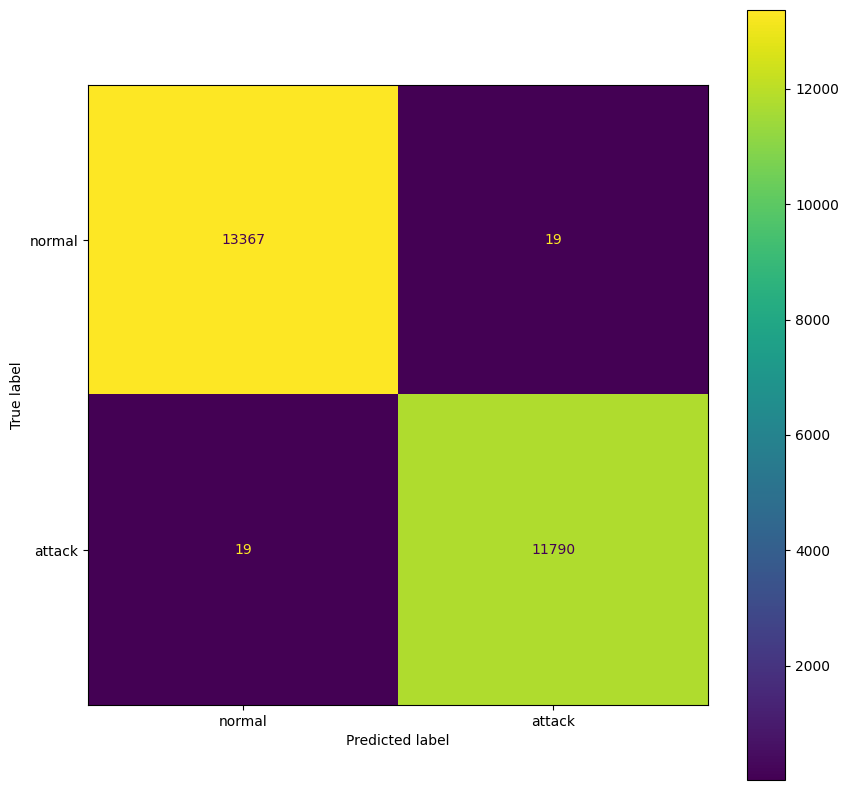

In [18]:
dt = DecisionTreeClassifier(max_depth=3).fit(x_train, y_train)
tdt = DecisionTreeClassifier().fit(x_train, y_train)
evaluate_classification(tdt, "DecisionTreeClassifier", x_train, x_test, y_train, y_test)

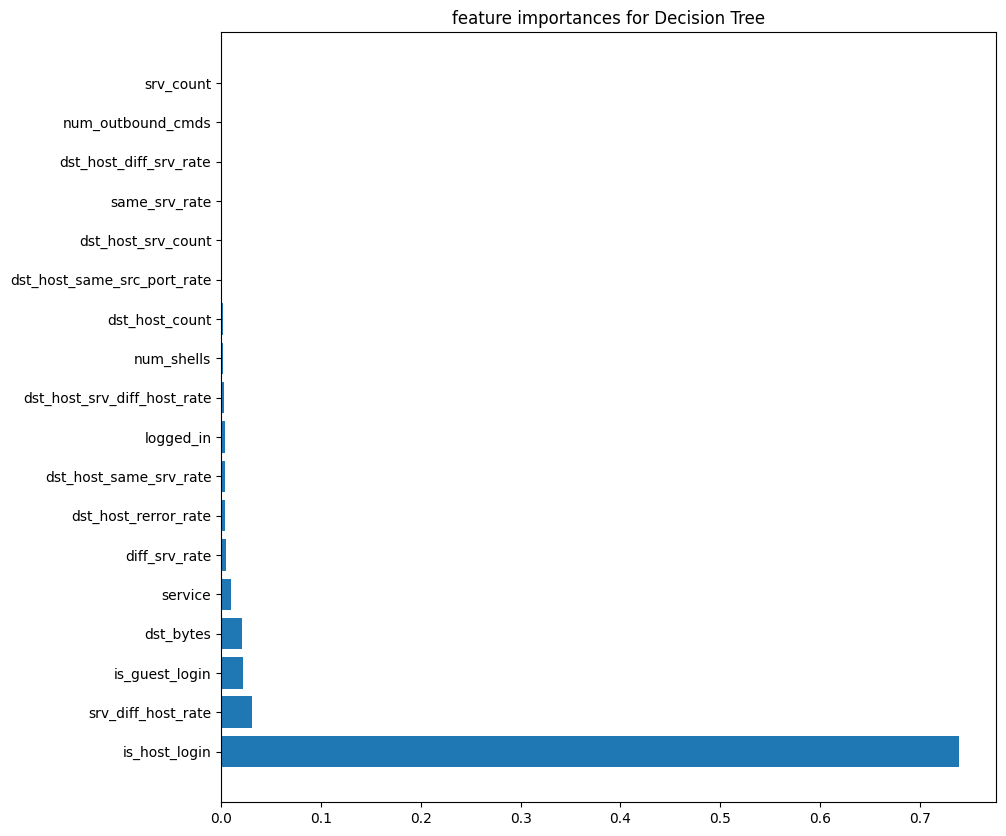

In [19]:
def f_importances(coef, names, top=-1):
    imp = coef
    imp, names = zip(*sorted(list(zip(imp, names))))

    # Show all features
    if top == -1:
        top = len(names)

    plt.figure(figsize=(10,10))
    plt.barh(range(top), imp[::-1][0:top], align='center')
    plt.yticks(range(top), names[::-1][0:top])
    plt.title('feature importances for Decision Tree')
    plt.show()

features_names = data_train.drop(['outcome', 'level'] , axis = 1)
f_importances(abs(tdt.feature_importances_), features_names, top=18)

[Text(0.5, 0.875, 'x[5] <= -0.056\ngini = 0.497\nsamples = 100777\nvalue = [53956, 46821]'),
 Text(0.25, 0.625, 'x[65] <= 0.5\ngini = 0.149\nsamples = 46560\nvalue = [3778, 42782]'),
 Text(0.125, 0.375, 'x[6] <= 0.005\ngini = 0.061\nsamples = 43088\nvalue = [1358, 41730]'),
 Text(0.0625, 0.125, 'gini = 0.031\nsamples = 42229\nvalue = [661, 41568]'),
 Text(0.1875, 0.125, 'gini = 0.306\nsamples = 859\nvalue = [697, 162]'),
 Text(0.375, 0.375, 'x[30] <= -0.211\ngini = 0.422\nsamples = 3472\nvalue = [2420, 1052]'),
 Text(0.3125, 0.125, 'gini = 0.021\nsamples = 1033\nvalue = [11, 1022]'),
 Text(0.4375, 0.125, 'gini = 0.024\nsamples = 2439\nvalue = [2409, 30]'),
 Text(0.75, 0.625, 'x[56] <= 0.5\ngini = 0.138\nsamples = 54217\nvalue = [50178, 4039]'),
 Text(0.625, 0.375, 'x[9] <= 0.5\ngini = 0.066\nsamples = 51813\nvalue = [50032, 1781]'),
 Text(0.5625, 0.125, 'gini = 0.027\nsamples = 49719\nvalue = [49043, 676]'),
 Text(0.6875, 0.125, 'gini = 0.498\nsamples = 2094\nvalue = [989, 1105]'),
 Te

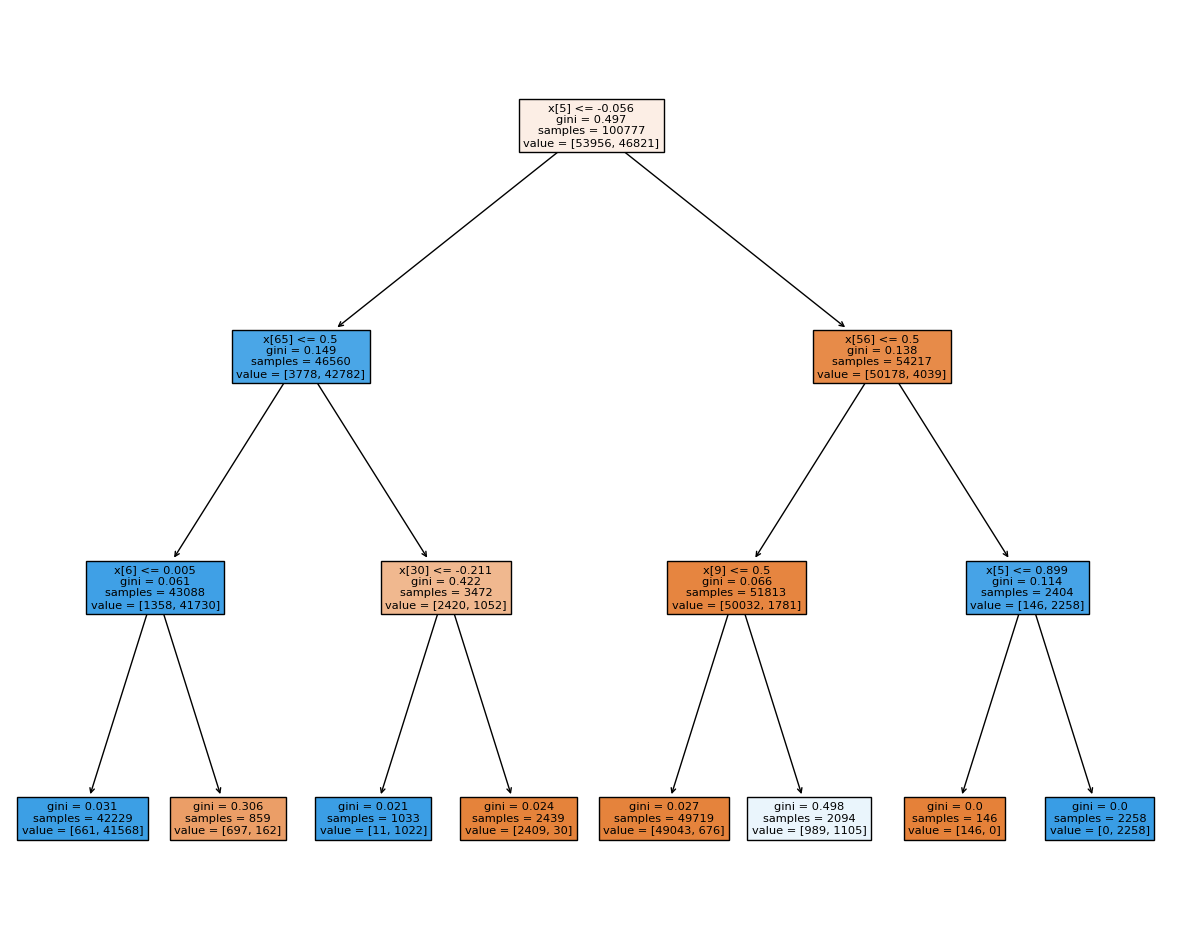

In [20]:
fig = plt.figure(figsize=(15,12))
tree.plot_tree(dt , filled=True)

## Neural networks

Neural networks, also known as artificial neural networks (ANNs) or simulated neural networks (SNNs), are a subset of machine learning and are at the heart of deep learning algorithms. Their name and structure are inspired by the human brain, mimicking the way that biological neurons signal to one another.
Artificial neural networks (ANNs) are comprised of a node layers, containing an input layer, one or more hidden layers, and an output layer. Each node, or artificial neuron, connects to another and has an associated weight and threshold. If the output of any individual node is above the specified threshold value, that node is activated, sending data to the next layer of the network. Otherwise, no data is passed along to the next layer of the network.

<img src= https://www.researchgate.net/publication/335903047/figure/fig1/AS:805611931443200@1569084260672/Proposed-artificial-neural-network-model-3-10-1-Neural-network-weight-vectors-are.png width=600/>

Neural networks rely on training data to learn and improve their accuracy over time. However, once these learning algorithms are fine-tuned for accuracy, they are powerful tools in computer science and artificial intelligence, allowing us to classify and cluster data at a high velocity. Tasks in speech recognition or image recognition can take minutes versus hours when compared to the manual identification by human experts. One of the most well-known neural networks is Google’s search algorithm.

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu', input_shape=(x_train.shape[1:]),
                          kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
                          bias_regularizer=regularizers.L2(1e-4),
                          activity_regularizer=regularizers.L2(1e-5)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(units=128, activation='relu',
                          kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
                          bias_regularizer=regularizers.L2(1e-4),
                          activity_regularizer=regularizers.L2(1e-5)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(units=512, activation='relu',
                          kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
                          bias_regularizer=regularizers.L2(1e-4),
                          activity_regularizer=regularizers.L2(1e-5)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(units=128, activation='relu',
                          kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
                          bias_regularizer=regularizers.L2(1e-4),
                          activity_regularizer=regularizers.L2(1e-5)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(units=1, activation='sigmoid'),
])

In [ ]:
model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10, verbose=1)

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('SCCE Loss')
plt.legend()
plt.grid(True)

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

In [ ]:
keys = [key for key in kernal_evals.keys()]
values = [value for value in kernal_evals.values()]
fig, ax = plt.subplots(figsize=(20, 6))
ax.bar(np.arange(len(keys)) - 0.2, [value[0] for value in values], color='darkred', width=0.25, align='center')
ax.bar(np.arange(len(keys)) + 0.2, [value[1] for value in values], color='y', width=0.25, align='center')
ax.legend(["Training Accuracy", "Test Accuracy"])
ax.set_xticklabels(keys)
ax.set_xticks(np.arange(len(keys)))
plt.ylabel("Accuracy")
plt.show()

In [ ]:
keys = [key for key in kernal_evals.keys()]
values = [value for value in kernal_evals.values()]
fig, ax = plt.subplots(figsize=(20, 6))
ax.bar(np.arange(len(keys)) - 0.2, [value[2] for value in values], color='g', width=0.25, align='center')
ax.bar(np.arange(len(keys)) + 0.2, [value[3] for value in values], color='b', width=0.25, align='center')
ax.legend(["Training Precesion", "Test Presision"])
ax.set_xticklabels(keys)
ax.set_xticks(np.arange(len(keys)))
plt.ylabel("Precesion")
plt.show()

In [ ]:
keys = [key for key in kernal_evals.keys()]
values = [value for value in kernal_evals.values()]
fig, ax = plt.subplots(figsize=(20, 6))
ax.bar(np.arange(len(keys)) - 0.2, [value[2] for value in values], color='g', width=0.25, align='center')
ax.bar(np.arange(len(keys)) + 0.2, [value[3] for value in values], color='b', width=0.25, align='center')
ax.legend(["Training Recall", "Test Recall"])
ax.set_xticklabels(keys)
ax.set_xticks(np.arange(len(keys)))
plt.ylabel("Recall")
plt.show()